# Real Hardware Fitting

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

## Expectation Value

## Two Qubit POVM Trace

In [2]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_POVM_trace.p", "rb"))
counts_error = counts_list[-16:]
corr_mat = sum([generate_corruption_matrix(counts_error[4*i:4*(i+1)]) for i in range(4)])/4
povm = corr_mat_to_povm(corr_mat)
print(corr_mat)

[[9.366e-01 5.169e-02 4.876e-02 2.837e-03]
 [1.645e-02 6.875e-04 9.045e-01 5.220e-02]
 [4.610e-02 9.363e-01 2.662e-03 4.974e-02]
 [8.250e-04 1.129e-02 4.407e-02 8.952e-01]]


In [3]:
target_list = []

for input, counts in zip(input_list, counts_list):
    observable = input[2]
    counts = counts
    target_list.append(counts_to_probs(counts))
    
input_train, input_test = input_list[:400], input_list[400:]
target_train, target_test = target_list[:400], target_list[400:]

In [193]:
n = 2
d = 2**n
rank = 7

circuit_target = qk.QuantumCircuit(n)
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
                       U = U,
                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_train,
                        target_list = target_train,
                        input_val_list = input_test,
                        target_val_list = target_test,
                        lr = 0.05, 
                        h = 1e-3
                        )

In [197]:
model.train(num_iter = 200,
            use_adam = True,
            N = 50
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0: fid: 0.00293, c: 0.726
1: fid: 0.00293, c: 0.724
2: fid: 0.00292, c: 0.723
3: fid: 0.00289, c: 0.723
4: fid: 0.00286, c: 0.722


KeyboardInterrupt: 

In [202]:
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.zeros(2**n)
observ[3] = 1
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[500-20-16:-16]]


for i in range(20):
    state_model = model.map_best.apply_map(state_model)
    model_expectation_list.append(expectation_value(measurement(state_model, povm=model.q_map.povm), observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

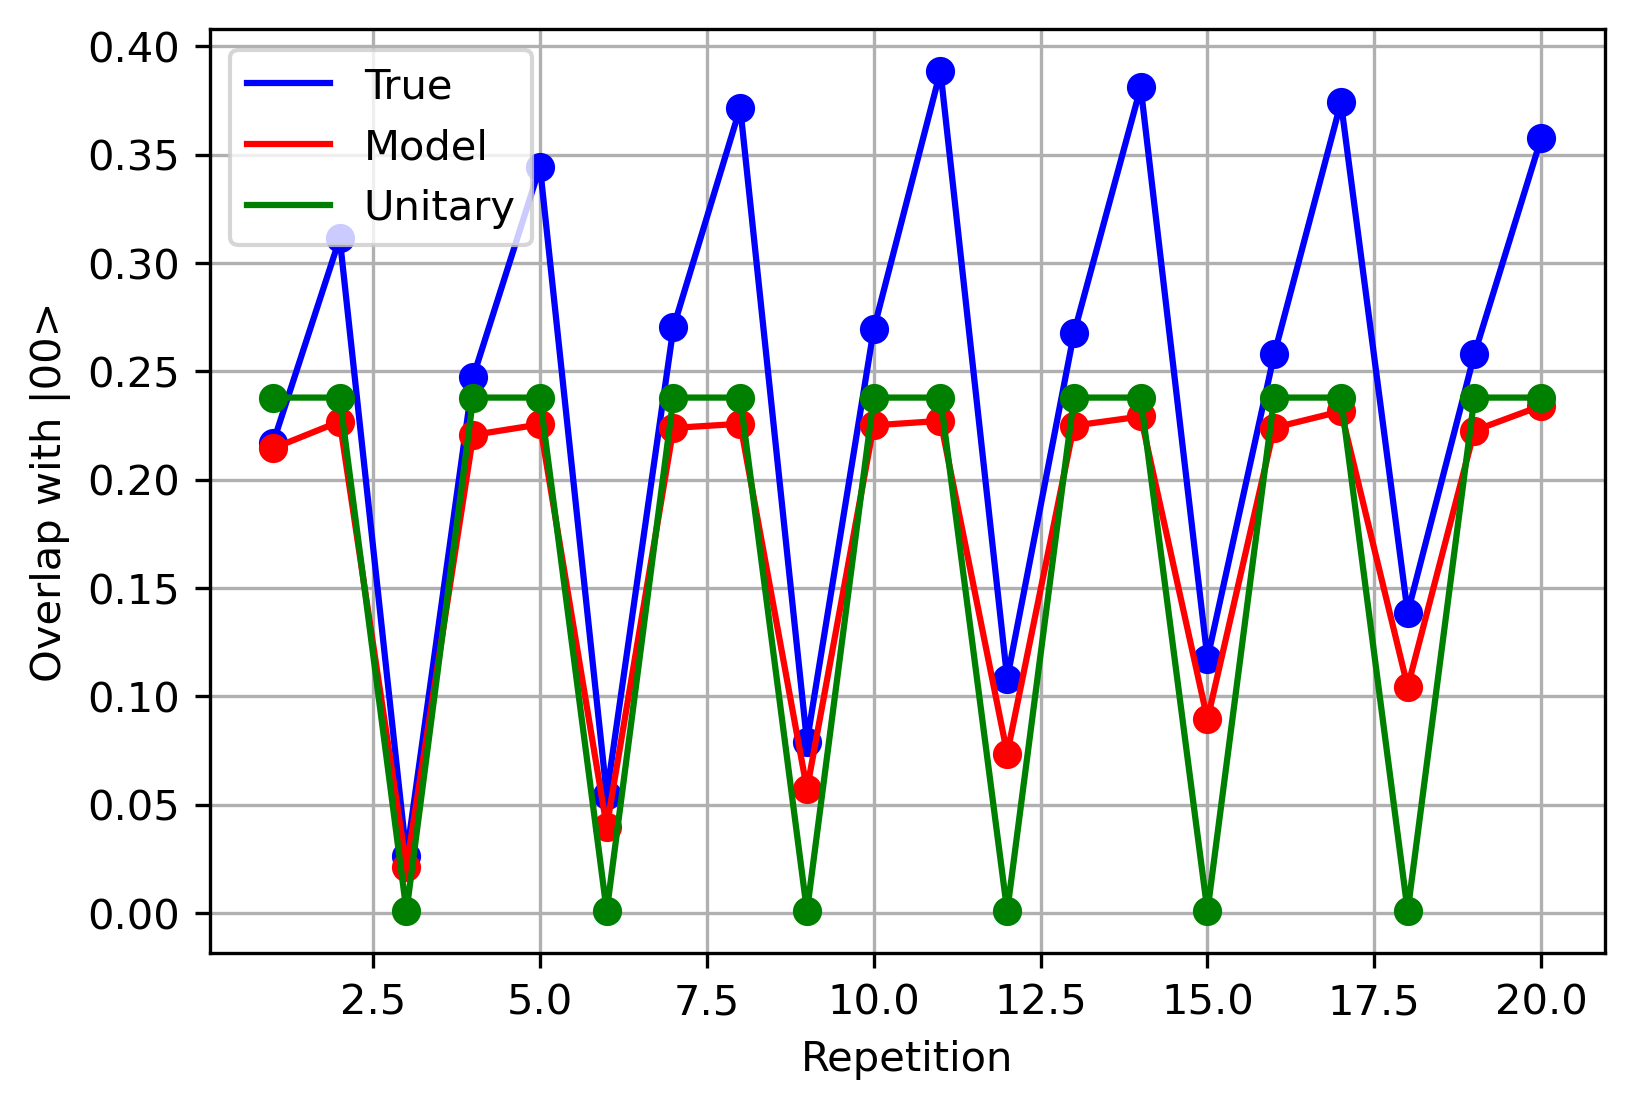

In [203]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

## Two Qubits POVM with Trace Ideal

In [ ]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_POVM_trace.p", "rb"))
counts_error = counts_list[-16:]
corr_mat = sum([generate_corruption_matrix(counts_error[4*i:4*(i+1)]) for i in range(4)])/4
povm = corr_mat_to_povm(corr_mat)
print(corr_mat)

## Two Qubit POVM with Trace

In [9]:
def variational_circuit(n):
    theta = np.random.uniform(-np.pi, np.pi, 4*n)
    circuit = qk.QuantumCircuit(n)
    for i, angle in enumerate(theta[:n]):
        circuit.ry(angle, i)
    
    for i, angle in enumerate(theta[n:2*n]):
        circuit.crx(angle, i, (i+1)%n)
        
    #for i, angle in enumerate(theta[2*n:3*n]):
    #    circuit.ry(angle, i)
        
    #for i, angle in enumerate(theta[3*n:]):
    #    circuit.crx(angle, (n-i)%n, n-i-1)
    
    return circuit

In [10]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_POVM_notrace.p", "rb"))
counts_error = counts_list[-16:]
corr_mat = sum([generate_corruption_matrix(counts_error[4*i:4*(i+1)]) for i in range(4)])/4
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(4, 4), dtype=complex64)
[[9.855e-01 2.131e-02 3.199e-02 6.125e-04]
 [6.612e-03 1.250e-04 9.600e-01 2.120e-02]
 [7.800e-03 9.715e-01 1.625e-04 3.213e-02]
 [6.250e-05 7.112e-03 7.875e-03 9.461e-01]]


In [11]:
target_list = []
input_list_ = []
for i in range(324):
    counts = counts_list[i]
    target_list.append(counts_to_probs(counts))
    state, U_basis, _ = input_list[i]
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), _])

input_list = input_list_

In [12]:
n = 2
d = 2**n
rank = 8
np.random.seed(42)
random.seed(42)

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm_ideal(n),
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [ ]:
model.train(num_iter = 200,
            N = 25
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.11628172+3.5316798e-09j)
1 (0.11459605+3.8430743e-09j)
2 (0.11238096+2.9555725e-09j)
3 (0.109707646+1.8391102e-09j)
4 (0.10682745+2.9284388e-09j)
5 (0.1042308+3.4003442e-09j)
6 (0.101650305+3.943148e-09j)
7 (0.09908279+3.3243923e-09j)
8 (0.09635361+3.4105747e-09j)


In [52]:
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.zeros(2**n)
observ[0] = 1
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[324:-16]]
counts_list[324:-16]


for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    model_expectation_list.append(expectation_value(measurement(state_model, povm=model.q_map.povm), observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

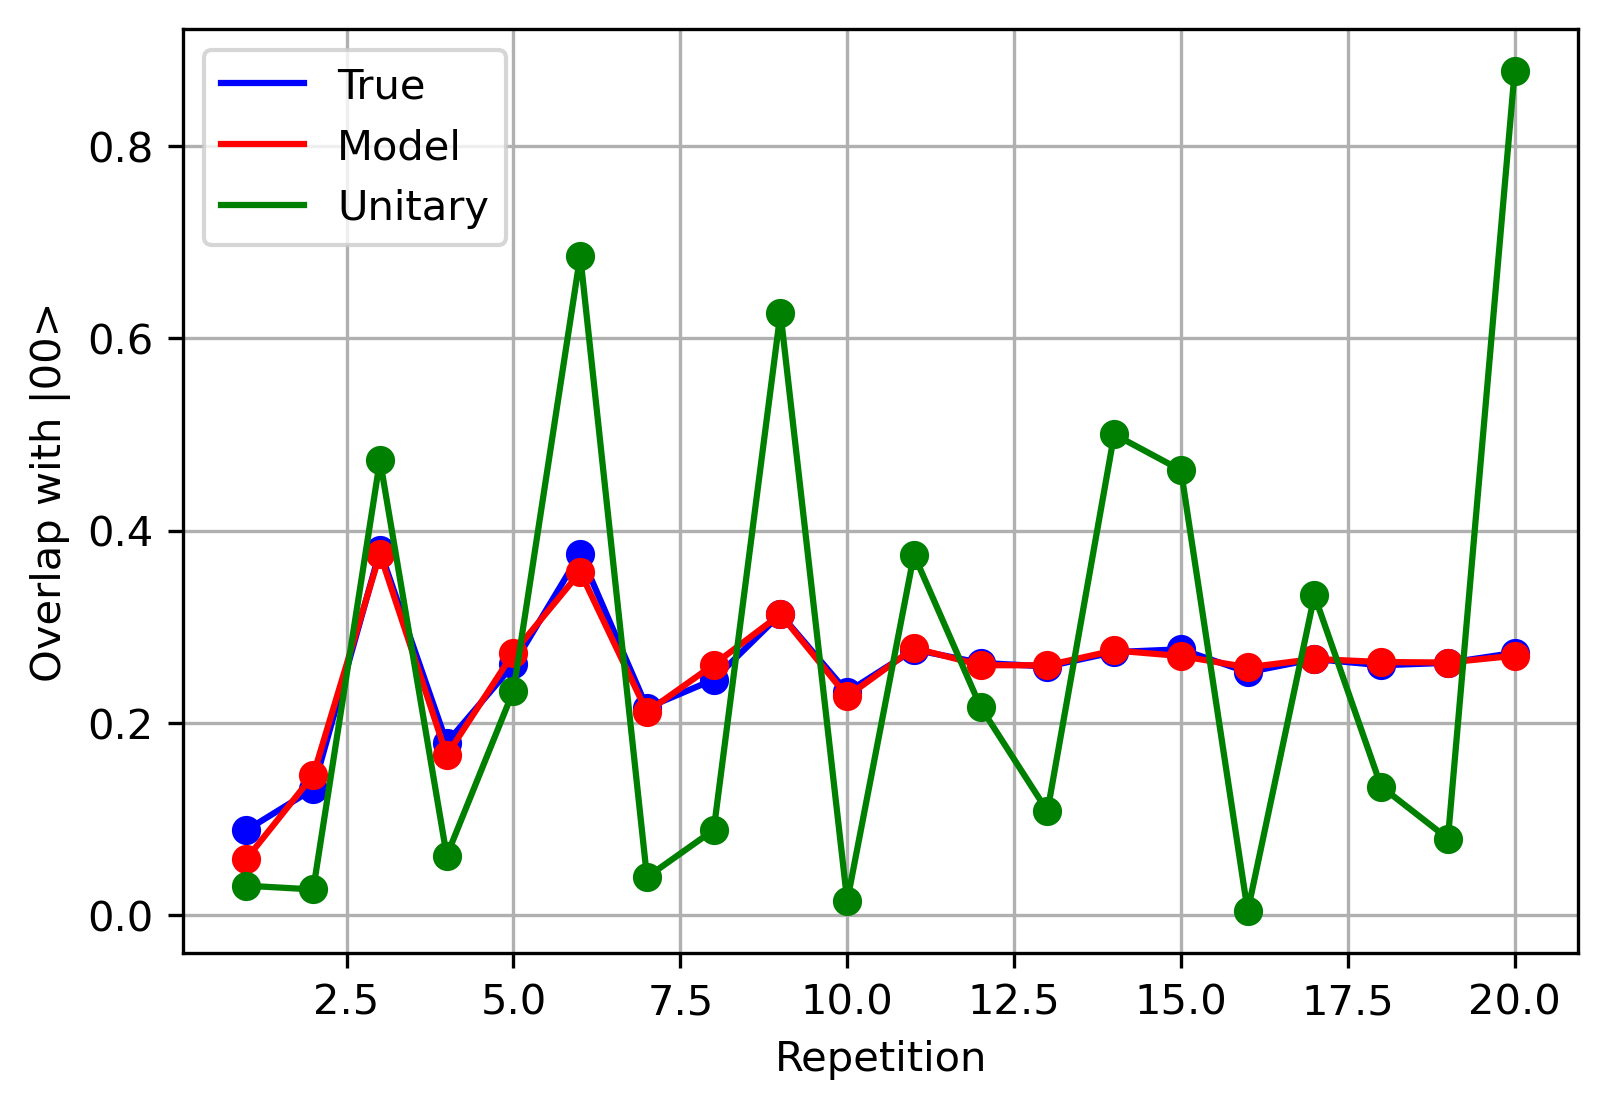

In [54]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

## Three Qubit Variational POVM

In [65]:
def variational_circuit(n):
    theta = np.random.uniform(-np.pi, np.pi, 4*n)
    circuit = qk.QuantumCircuit(n)
    for i, angle in enumerate(theta[:n]):
        circuit.ry(angle, i)
    
    for i, angle in enumerate(theta[n:2*n]):
        circuit.crx(angle, i, (i+1)%n)
        
    #for i, angle in enumerate(theta[2*n:3*n]):
    #    circuit.ry(angle, i)
        
    #for i, angle in enumerate(theta[3*n:]):
    #    circuit.crx(angle, (n-i)%n, n-i-1)
    
    return circuit

In [67]:
n = 3
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\threeQubits_expectation_POVM.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(corr_mat)
print(sum(povm))

[[9.718e-01 3.200e-02 2.161e-02 6.312e-04 2.289e-02 6.812e-04 4.500e-04
  1.875e-05]
 [7.431e-03 9.478e-01 1.125e-04 2.109e-02 1.437e-04 2.186e-02 0.000e+00
  5.375e-04]
 [7.469e-03 2.312e-04 9.584e-01 3.158e-02 1.687e-04 6.250e-06 2.191e-02
  7.562e-04]
 [8.125e-05 7.306e-03 7.162e-03 9.336e-01 0.000e+00 1.563e-04 1.063e-04
  2.205e-02]
 [1.300e-02 4.188e-04 2.500e-04 2.500e-05 9.623e-01 3.181e-02 2.178e-02
  7.437e-04]
 [1.000e-04 1.214e-02 6.250e-06 3.250e-04 6.687e-03 9.378e-01 1.375e-04
  2.131e-02]
 [9.375e-05 0.000e+00 1.238e-02 3.500e-04 7.744e-03 2.562e-04 9.488e-01
  3.112e-02]
 [0.000e+00 1.000e-04 1.188e-04 1.243e-02 3.125e-05 7.481e-03 6.819e-03
  9.235e-01]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [14]:
target_list = []

N = 300

for input, counts in zip(input_list, counts_list):
    observable = input[2]
    counts = counts
    target_list.append(counts_to_probs(counts))
    
input_train, input_test = input_list[:N], input_list[N:]
target_train, target_test = target_list[:N], target_list[N:] 

In [15]:
n = 2
d = 2**n
rank = 8
np.random.seed(42)
random.seed(42)

U = Operator(variational_circuit(n).reverse_bits()).data

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        cost = probs_loss,
                        input_list = input_train,
                        target_list = target_train,
                        input_val_list = input_test,
                        target_val_list = target_test,
                        lr = 0.05, 
                        h = 1e-3
                        )

In [16]:
model.train(num_iter = 200,
            use_adam = True,
            N = 25
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0: fid: 0.16882, c: 0.500
1: fid: 0.16617, c: 0.500
2: fid: 0.16274, c: 0.500
3: fid: 0.15860, c: 0.500
4: fid: 0.15483, c: 0.500
5: fid: 0.15097, c: 0.500
6: fid: 0.14672, c: 0.500
7: fid: 0.14226, c: 0.500
8: fid: 0.13765, c: 0.500
9: fid: 0.13267, c: 0.500
10: fid: 0.12765, c: 0.500
11: fid: 0.12239, c: 0.500
12: fid: 0.11691, c: 0.500
13: fid: 0.11163, c: 0.500
14: fid: 0.10634, c: 0.500
15: fid: 0.10088, c: 0.500
16: fid: 0.09552, c: 0.500
17: fid: 0.09033, c: 0.500
18: fid: 0.08501, c: 0.500
19: fid: 0.08012, c: 0.500
20: fid: 0.07538, c: 0.500
21: fid: 0.07074, c: 0.500
22: fid: 0.06610, c: 0.500
23: fid: 0.06163, c: 0.500
24: fid: 0.05713, c: 0.500
25: fid: 0.05279, c: 0.500
26: fid: 0.04873, c: 0.500
27: fid: 0.04493, c: 0.500
28: fid: 0.04127, c: 0.500
29: fid: 0.03782, c: 0.500
30: fid: 0.03472, c: 0.500
31: fid: 0.03182, c: 0.500
32: fid: 0.02910, c: 0.500
33: fid: 0.02657, c: 0.500
34: fid: 0.02423, c: 0.500
35: fid: 0.02215, c: 0.500
36: fid: 0.02022, c: 0.500
37: fid: 0.

In [23]:
state_unitary = state_model = np.zeros((d,d))
state_unitary[0,0] = 1
observ = np.zeros(d)
observ[3] = 1
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[324:-16]]


for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    model_expectation_list.append(expectation_value(measurement(state_model, povm=model.q_map.povm), observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

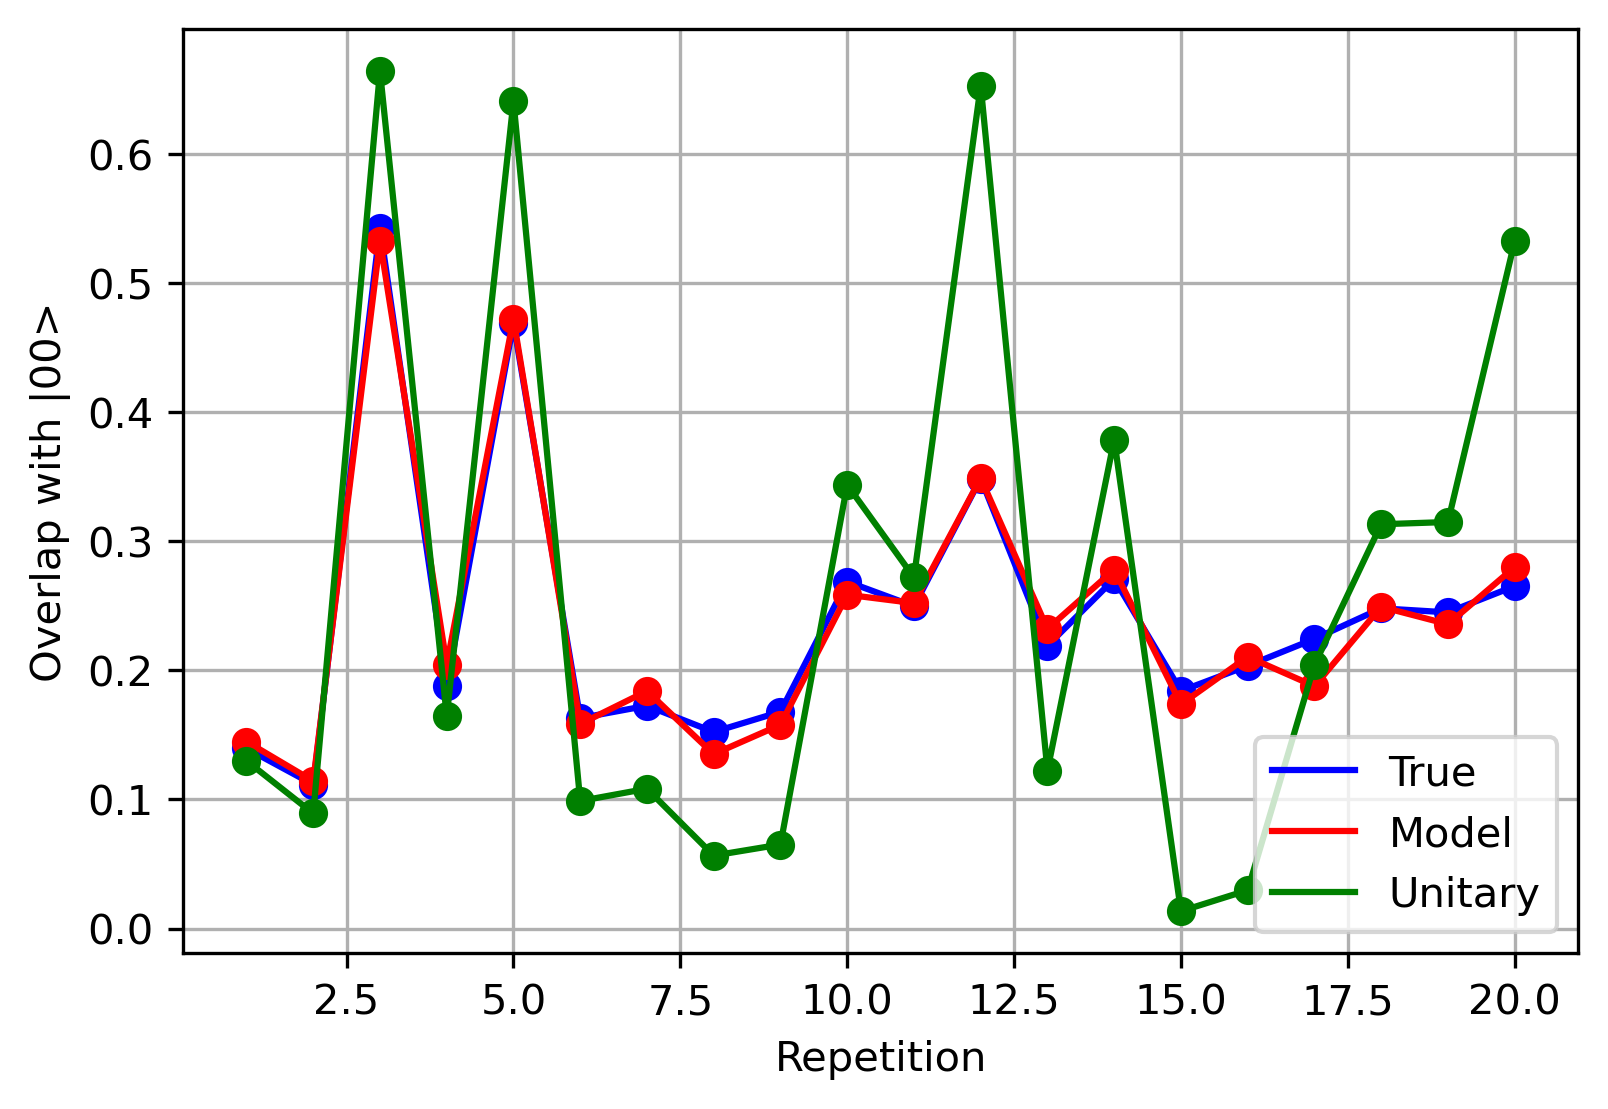

In [24]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

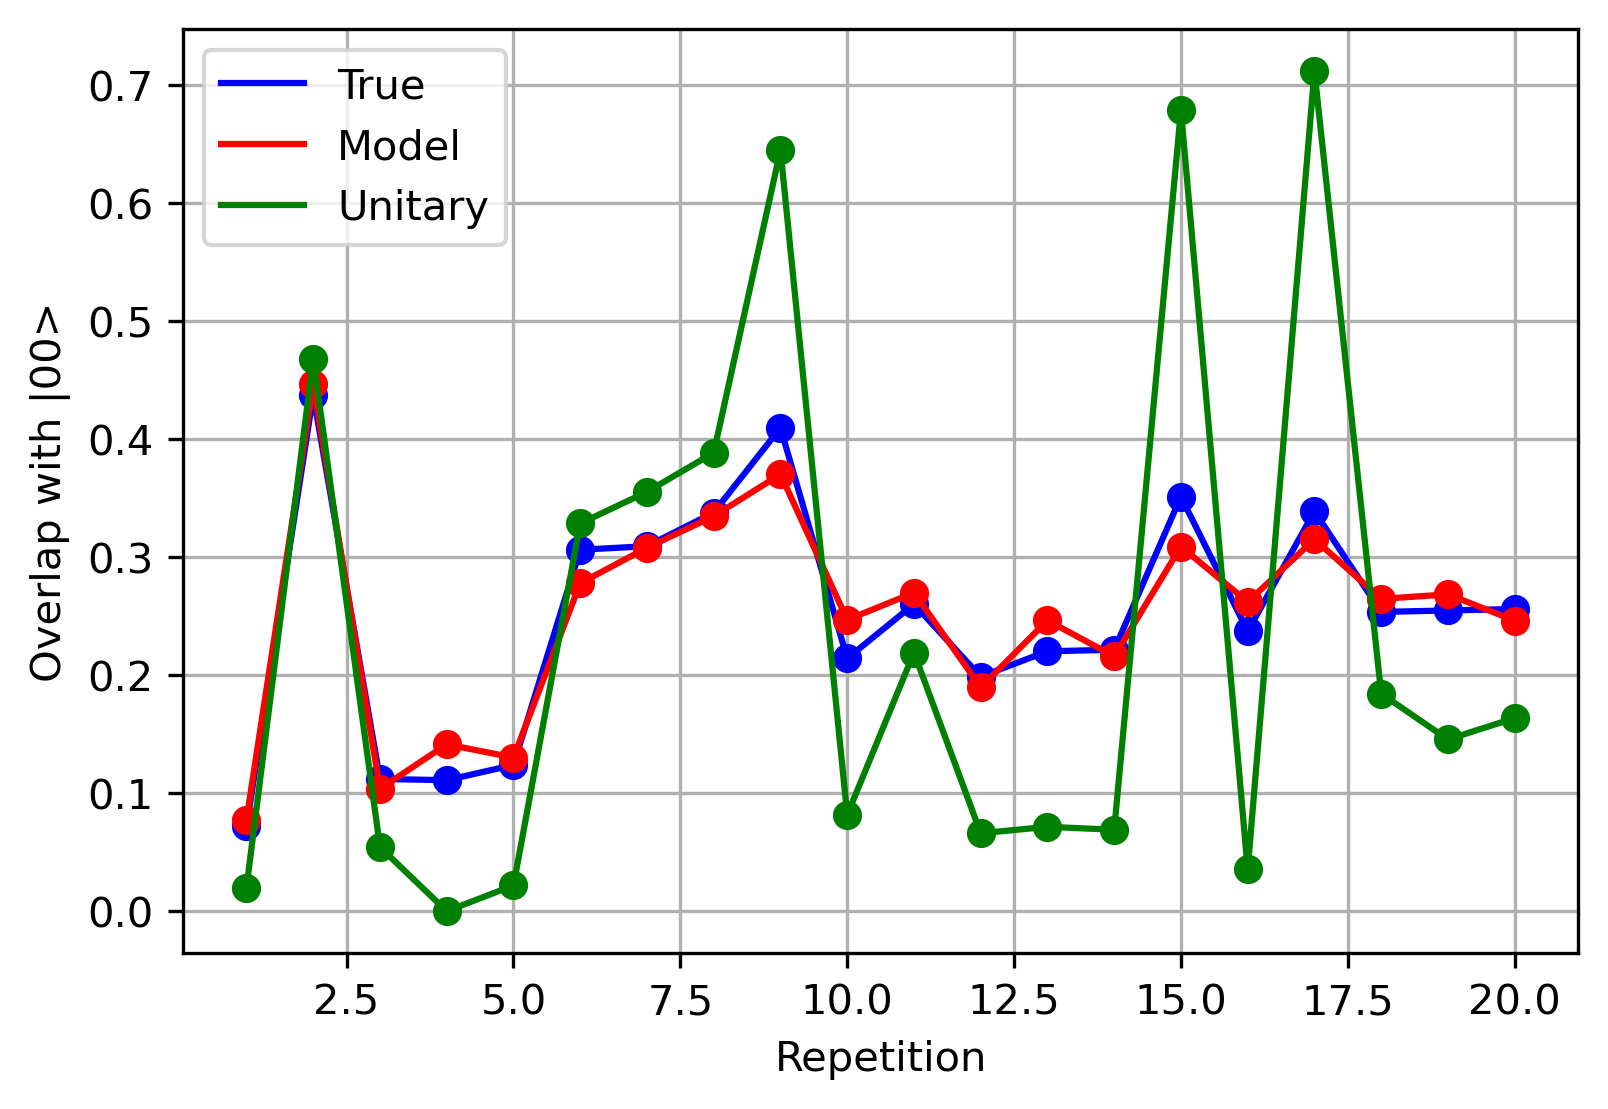

In [10]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

## Three Qubit Variational

In [51]:
n = 3
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\threeQubits_expectation_POVM.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(corr_mat)
print(sum(povm))

[[9.718e-01 3.200e-02 2.161e-02 6.312e-04 2.289e-02 6.812e-04 4.500e-04
  1.875e-05]
 [7.431e-03 9.478e-01 1.125e-04 2.109e-02 1.437e-04 2.186e-02 0.000e+00
  5.375e-04]
 [7.469e-03 2.312e-04 9.584e-01 3.158e-02 1.687e-04 6.250e-06 2.191e-02
  7.562e-04]
 [8.125e-05 7.306e-03 7.162e-03 9.336e-01 0.000e+00 1.563e-04 1.063e-04
  2.205e-02]
 [1.300e-02 4.188e-04 2.500e-04 2.500e-05 9.623e-01 3.181e-02 2.178e-02
  7.437e-04]
 [1.000e-04 1.214e-02 6.250e-06 3.250e-04 6.687e-03 9.378e-01 1.375e-04
  2.131e-02]
 [9.375e-05 0.000e+00 1.238e-02 3.500e-04 7.744e-03 2.562e-04 9.488e-01
  3.112e-02]
 [0.000e+00 1.000e-04 1.188e-04 1.243e-02 3.125e-05 7.481e-03 6.819e-03
  9.235e-01]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [52]:
target_list = []

N = 900

for input, counts in zip(input_list, counts_list):
    observable = input[2]
    counts = counts
    target_list.append(counts_to_probs(counts))
    
input_train, input_test = input_list[:N], input_list[N:]
target_train, target_test = target_list[:N], target_list[N:] 

In [53]:
n = 3
d = 2**n
rank = 16
np.random.seed(42)
random.seed(42)

U = Operator(variational_circuit(n).reverse_bits()).data

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        cost = probs_loss,
                        input_list = input_train,
                        target_list = target_train,
                        input_val_list = input_test,
                        target_val_list = target_test,
                        lr = 0.05, 
                        h = 1e-3
                        )

In [54]:
model.train(num_iter = 500,
            use_adam = True,
            N = 25
            )

  0%|          | 0/500 [00:00<?, ?it/s]

0: fid: 0.08492, c: 0.500
1: fid: 0.08370, c: 0.500
2: fid: 0.08214, c: 0.500
3: fid: 0.08038, c: 0.500
4: fid: 0.07854, c: 0.500
5: fid: 0.07668, c: 0.500
6: fid: 0.07489, c: 0.500
7: fid: 0.07298, c: 0.500
8: fid: 0.07117, c: 0.500
9: fid: 0.06941, c: 0.500
10: fid: 0.06770, c: 0.500
11: fid: 0.06597, c: 0.500
12: fid: 0.06424, c: 0.500
13: fid: 0.06246, c: 0.500
14: fid: 0.06073, c: 0.500
15: fid: 0.05898, c: 0.500
16: fid: 0.05728, c: 0.500
17: fid: 0.05553, c: 0.500
18: fid: 0.05385, c: 0.500
19: fid: 0.05217, c: 0.500
20: fid: 0.05048, c: 0.500
21: fid: 0.04879, c: 0.500
22: fid: 0.04714, c: 0.500
23: fid: 0.04549, c: 0.500
24: fid: 0.04385, c: 0.500
25: fid: 0.04226, c: 0.500
26: fid: 0.04070, c: 0.500
27: fid: 0.03914, c: 0.500
28: fid: 0.03764, c: 0.500
29: fid: 0.03619, c: 0.500
30: fid: 0.03479, c: 0.500
31: fid: 0.03344, c: 0.500
32: fid: 0.03217, c: 0.500
33: fid: 0.03090, c: 0.500
34: fid: 0.02968, c: 0.500
35: fid: 0.02848, c: 0.500
36: fid: 0.02732, c: 0.500
37: fid: 0.

297: fid: 0.00024, c: 0.500
298: fid: 0.00023, c: 0.500
299: fid: 0.00023, c: 0.500
300: fid: 0.00023, c: 0.500
301: fid: 0.00023, c: 0.500
302: fid: 0.00022, c: 0.500
303: fid: 0.00022, c: 0.500
304: fid: 0.00022, c: 0.500
305: fid: 0.00022, c: 0.500
306: fid: 0.00022, c: 0.500
307: fid: 0.00022, c: 0.500
308: fid: 0.00022, c: 0.500
309: fid: 0.00022, c: 0.500
310: fid: 0.00022, c: 0.500
311: fid: 0.00022, c: 0.500
312: fid: 0.00022, c: 0.500
313: fid: 0.00022, c: 0.500
314: fid: 0.00022, c: 0.500
315: fid: 0.00022, c: 0.500
316: fid: 0.00022, c: 0.500
317: fid: 0.00022, c: 0.500
318: fid: 0.00022, c: 0.500
319: fid: 0.00022, c: 0.500
320: fid: 0.00022, c: 0.500
321: fid: 0.00022, c: 0.500
322: fid: 0.00022, c: 0.500
323: fid: 0.00022, c: 0.500
324: fid: 0.00022, c: 0.500
325: fid: 0.00022, c: 0.500
326: fid: 0.00022, c: 0.500
327: fid: 0.00022, c: 0.500
328: fid: 0.00022, c: 0.500
329: fid: 0.00022, c: 0.500
330: fid: 0.00022, c: 0.500
331: fid: 0.00022, c: 0.500
332: fid: 0.00022, c

In [60]:
state_unitary = state_model = np.zeros((d,d))
state_unitary[0,0] = 1
observ = np.zeros(d)
observ[2] = 1
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[1000:-64]]


for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    model_expectation_list.append(expectation_value(measurement(state_model, povm=model.q_map.povm), observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

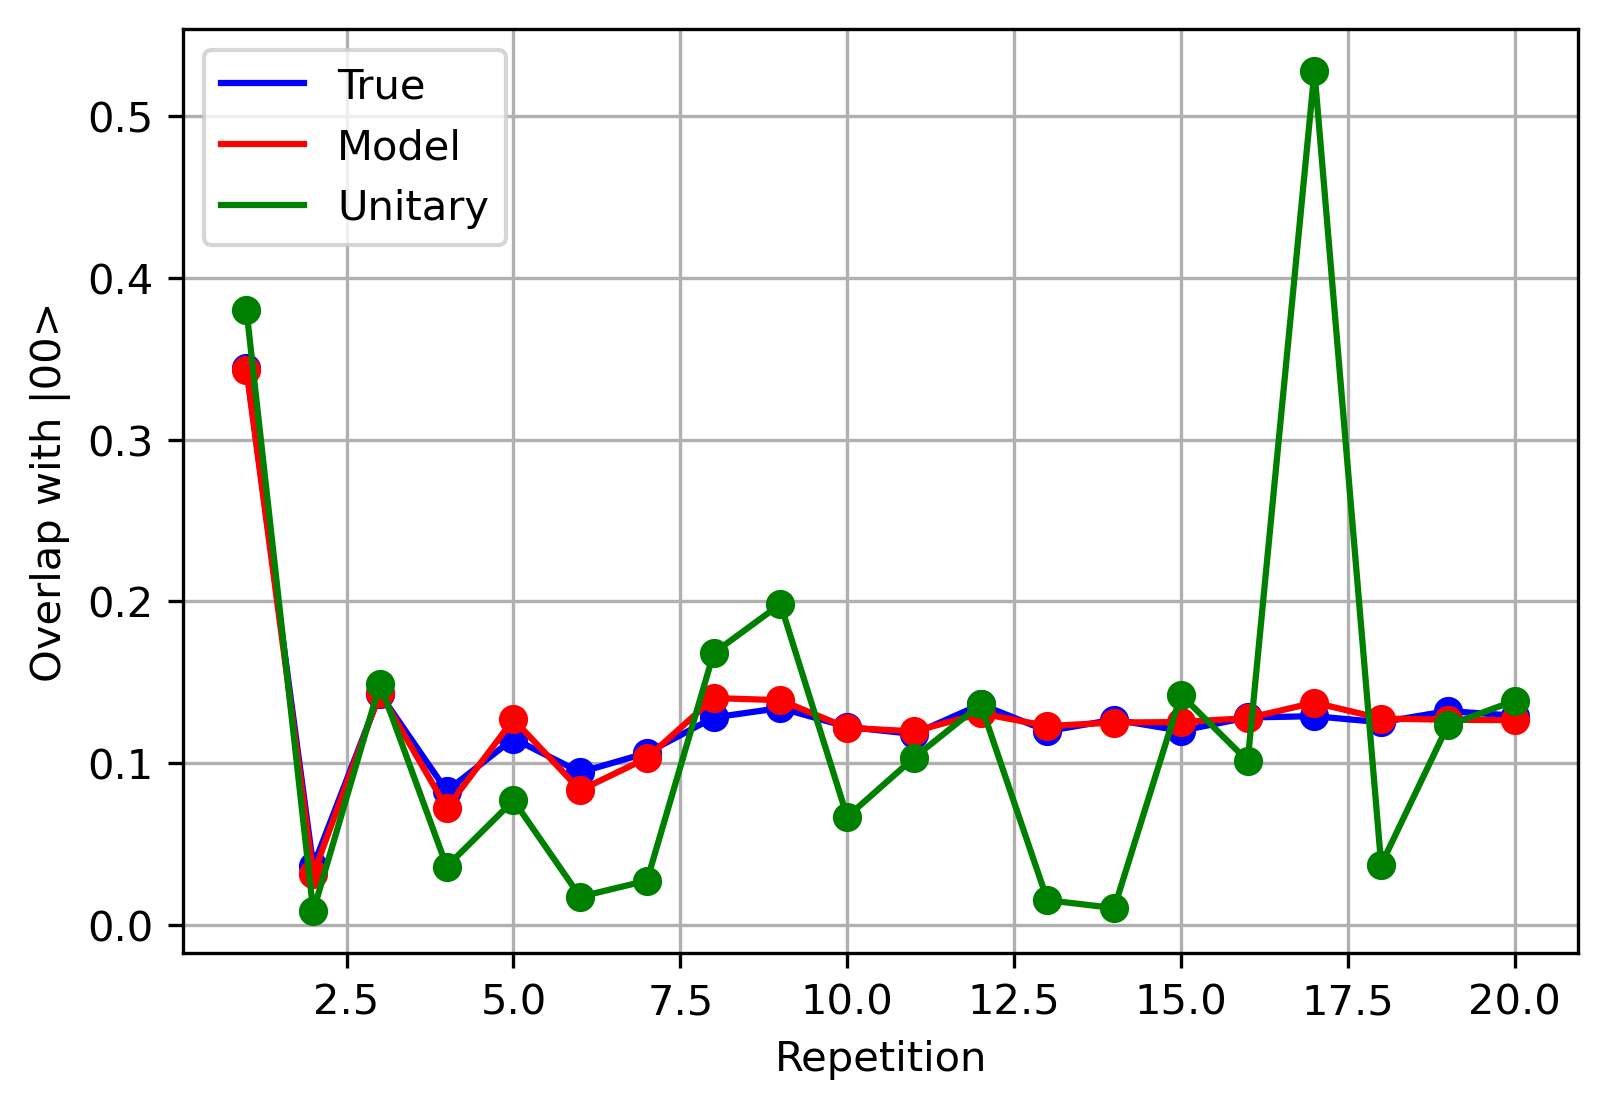

In [61]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

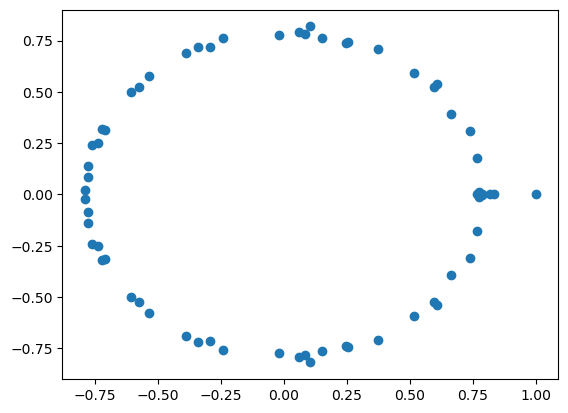

In [57]:
choi = maps_to_choi([model.q_map])
spectrum = choi_spectrum(choi)

plt.plot(*spectrum, "o")
plt.show()